# 0.0 Imports

In [286]:
import random
import pickle

import pandas                                     as pd
import numpy                                      as np
import seaborn                                    as sns
import ipywidgets                                 as widgets

from datetime              import datetime        as dt
from xgboost               import XGBClassifier   
from matplotlib            import pyplot          as plt
from sklearn               import model_selection as ms
from sklearn               import preprocessing   as pp
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn               import metrics         as m

from scikitplot            import metrics         as mt
from scipy                 import stats           as ss


from keras                 import models          as ml
from keras                 import layers          as l

from imblearn              import under_sampling  as us
from imblearn              import over_sampling   as oversample
from imblearn              import combine         as c

from ydata_profiling       import ProfileReport

from category_encoders     import TargetEncoder

from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor

from sklearn.neighbors     import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

## 0.1 - Helper Functions

In [ ]:
def cramer_v( x, y ):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( ( chi2corr/n ) / ( min( kcorr - 1, rcorr - 1 ) ) )


In [ ]:
def obter_estacao(date):
    
    mes = date.month
    dia = date.day
    
    if (dia >= 21 and mes == 12) or (dia >= 1 and mes < 3) or (dia <= 19 and mes == 3):
        return 'Winter'
    
    elif (dia >= 20 and mes == 3) or (dia >= 1 and mes < 6) or (dia <= 19 and mes == 6):
        return 'Spring'
    
    elif (dia >= 20 and mes == 6) or (dia >= 1 and mes < 9) or (dia <= 21 and mes == 9):
        return 'Summer'
    
    else:
        return 'Fall'

In [ ]:
def age(age):
    
    if age <= 29:
        return 'Young'
    
    elif age <= 65:
        return 'Adult'
    
    else:
        return 'Old'

In [392]:
def prepare_data(df):
    
    df = df.drop(['date_first_booking'], axis = 1)
    
    #==============Remove Nan================

    #age

    df = df[(df['age'] >= 18) & (df['age'] < 120)]
    avg_age = df['age'].mean().astype(int)
    df['age'] = df['age'].fillna(avg_age)

    #first_affiliate_tracked

    df = df[~ df['first_affiliate_tracked'].isna()]
    
    #================Change Types=========================
    
    
    #date_account_created

    df['date_account_created'] = pd.to_datetime(df['date_account_created'])

    #timestamp_first_active

    df['timestamp_first_active'] = pd.to_datetime(df['timestamp_first_active'], format = '%Y%m%d%H%M%S')

    #age

    df['age'] = df['age'].astype(np.int64)
    
    df2 = df.copy()
    
    #=========================New Features=========================
    
    df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%d-%m-%Y'))
    df2['date_account_created'] = pd.to_datetime(df2['date_account_created'].dt.strftime('%d-%m-%Y'))


    #days from first active up to account created

    df2['days_from_account_created_until_active'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

    #days from first active until account created

    df2['days_from_first_active_until_account_created'] = (df2['first_active'] - df2['date_account_created']).apply(lambda x: x.days)



    #===============================First Active=========================================================

    #Year of first active

    df2['year_first_active'] = df2['first_active'].dt.year

    #Month of first active

    df2['month_first_active'] = df2['first_active'].dt.month
    
    #Day of first active

    df2['day_first_active'] = df2['first_active'].dt.day

    #Day of week of first active

    df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

    #Week of year first active

    df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear


#===============================date account created=========================================================


    #Year of account created

    df2['year_account_created'] = df2['date_account_created'].dt.year

    #Month of account created

    df2['month_account_created'] = df2['date_account_created'].dt.month

    #Day of account created

    df2['day_account_created'] = df2['date_account_created'].dt.day

    #Day of week of account created

    df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

    #Week of year account created

    df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

#===============================station_of_year=========================================================


    df2['station_of_year'] = df2['date_account_created'].apply(obter_estacao)

#==============================type_age============================================================

    df2['type_age'] = df2['age'].apply(age)
    
    df3 = df2.copy()
    
    #===================Filtering Rows and Columns=====================================
    
    df3 = df3[(df3['age'] > 15) & (df3['age'] < 120)]
    
    cols = ['id','date_account_created','timestamp_first_active','first_active'] #original datetime  
    
    #======================Encoders===================================
    
    df4 = df3.drop(cols, axis = 1)
    
    # columns numerical

    col_num = df4.select_dtypes(include = ['int64','float64']).columns.tolist()

    # columns categorical

    col_cat = df4.select_dtypes(exclude = ['int64','float64','datetime64[ns]']).columns.tolist()

    # Encoder

    ohe = pp.OneHotEncoder()

    df4_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(), index = df4.index)

    #Join

    df42 = pd.concat([df4[col_num], df4_dummy], axis = 1)

    df42.columns = df42.columns.astype(str)
    
    df45 = pd.DataFrame(ohe.inverse_transform(df4_dummy), columns = col_cat, index = df4_dummy.index)
    
    df46 = pd.concat([df4[col_num], df45], axis = 1)
    
    #======================Remove columns with High correlation and Transformations =============================
    
    df6 = df46.drop(columns = 'language')
    
    ss = pp.StandardScaler()
    rs = pp.RobustScaler()
    mms = pp.MinMaxScaler()
    le = pp.LabelEncoder()
    
    #RESCALING
    
    # Age - Standartization

    df6['age'] = ss.fit_transform(df6[['age']].values)

    #signup_flow - Robust Scaler

    df6['signup_flow'] = rs.fit_transform(df6[['signup_flow']].values)

    #days_from_account_created_until_active - Robust Scaler

    df6['days_from_account_created_until_active'] = rs.fit_transform(df6[['days_from_account_created_until_active']].values)

    #days_from_first_active_until_account_created

    df6['days_from_first_active_until_account_created'] = rs.fit_transform(df6[['days_from_first_active_until_account_created']].values)

    #year_first_active - Min Max Scaler

    df6['year_first_active'] = mms.fit_transform(df6[['year_first_active']].values)

    #year_account_created

    df6['year_account_created'] = mms.fit_transform(df6[['year_account_created']].values)

    
    #ENCODER
    
    #gender - OHE

    df6 = pd.get_dummies(df6, prefix = ['gender'], columns = ['gender'])

    #signup_method - OHE

    df6 = pd.get_dummies(df6, prefix = ['signup_method'], columns = ['signup_method'])

    #signup_app - OHE

    df6 = pd.get_dummies(df6, prefix = ['signup_app'], columns = ['signup_app'])

    #affiliate_channel - Label encoding

    df6['affiliate_channel'] = np.int64(le.fit_transform(df6[['affiliate_channel']].values))

    #affiliate_provider - Label encoding

    df6['affiliate_provider'] = np.int64(le.fit_transform(df6[['affiliate_provider']].values))

    #first_affiliate_tracked - Label encoding

    df6['first_affiliate_tracked'] = np.int64(le.fit_transform(df6[['first_affiliate_tracked']].values))

    #first_device_type - Label encoding

    df6['first_device_type'] = np.int64(le.fit_transform(df6[['first_device_type']].values))

    #first_browser - Label encoding

    df6['first_browser'] = np.int64(le.fit_transform(df6[['first_browser']].values))

    #station_of_year

    df6 = pd.get_dummies(df6, prefix = ['station_of_year'], columns = ['station_of_year'])
    
    #type_age

    df6 = pd.get_dummies(df6, prefix = ['type_age'], columns = ['type_age'])
    
    #TRANSFORMATION
    
    #day_first_active

    df6['day_first_active_sin'] = df6['day_first_active'].apply(lambda x: np.sin(x * (2*np.pi/7)))
    df6['day_first_active_cos'] = df6['day_first_active'].apply(lambda x: np.cos(x * (2*np.pi/7)))

    #day_of_week_first_active

    df6['day_of_week_first_active_sin'] = df6['day_of_week_first_active'].apply(lambda x: np.sin(x * (2*np.pi/7)))
    df6['day_of_week_first_active_cos'] = df6['day_of_week_first_active'].apply(lambda x: np.cos(x * (2*np.pi/7)))

    #day_of_week_first_active

    df6['day_of_week_first_active_sin'] = df6['day_of_week_first_active'].apply(lambda x: np.sin(x * (2*np.pi/7)))
    df6['day_of_week_first_active_cos'] = df6['day_of_week_first_active'].apply(lambda x: np.cos(x * (2*np.pi/7)))

    #week_of_year_first_active

    df6['week_of_year_first_active_sin'] = df6['week_of_year_first_active'].apply(lambda x: np.sin(x * (2*np.pi/52)))
    df6['week_of_year_first_active_cos'] = df6['week_of_year_first_active'].apply(lambda x: np.cos(x * (2*np.pi/52)))

#=======================================================================================================================

    #day_account_created

    df6['day_account_created_sin'] = df6['day_account_created'].apply(lambda x: np.sin(x * (2*np.pi/7)))
    df6['day_account_created_cos'] = df6['day_account_created'].apply(lambda x: np.cos(x * (2*np.pi/7)))

    #day_of_week_account_created

    df6['day_of_week_account_created_sin'] = df6['day_of_week_account_created'].apply(lambda x: np.sin(x * (2*np.pi/7)))
    df6['day_of_week_account_created_cos'] = df6['day_of_week_account_created'].apply(lambda x: np.cos(x * (2*np.pi/7)))

    #day_of_week_account_created

    df6['day_of_week_account_created_sin'] = df6['day_of_week_account_created'].apply(lambda x: np.sin(x * (2*np.pi/7)))
    df6['day_of_week_account_created_cos'] = df6['day_of_week_account_created'].apply(lambda x: np.cos(x * (2*np.pi/7)))

    #week_of_year_account_created

    df6['week_of_year_account_created_sin'] = df6['week_of_year_account_created'].apply(lambda x: np.sin(x * (2*np.pi/52)))
    df6['week_of_year_account_created_cos'] = df6['week_of_year_account_created'].apply(lambda x: np.cos(x * (2*np.pi/52)))
    
    
    cols_feature_importance_drop = ['days_from_first_active_until_account_created', 'signup_method_weibo']
    
    #========================Feature Selection===================================
    
    df_test_prepared = df6.drop(cols_feature_importance_drop, axis = 1).copy()
    
    return df_test_prepared

## 0.2 - Loading data

In [3]:
df_raw = pd.read_csv('C:/Users/gabriel.ferreira/repos/PA/P001-AirBNB/train_users.csv')
df_test = pd.read_csv('C:/Users/gabriel.ferreira/repos/PA/P001-AirBNB/test_users.csv')

# 1.0 Description Data

In [4]:
df1 = df_raw.copy()
df1_sessions = df_sessions_raw.copy()

### 1.0.1 Description Train and Test

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       62096 non-null  object 
 1   date_account_created     62096 non-null  object 
 2   timestamp_first_active   62096 non-null  int64  
 3   date_first_booking       0 non-null      float64
 4   gender                   62096 non-null  object 
 5   age                      33220 non-null  float64
 6   signup_method            62096 non-null  object 
 7   signup_flow              62096 non-null  int64  
 8   language                 62096 non-null  object 
 9   affiliate_channel        62096 non-null  object 
 10  affiliate_provider       62096 non-null  object 
 11  first_affiliate_tracked  62076 non-null  object 
 12  signup_app               62096 non-null  object 
 13  first_device_type        62096 non-null  object 
 14  first_browser         

## 1.1 Data Dimensions

In [8]:
df1 = df1.drop(['date_first_booking'], axis = 1)
print('df1 - Number of rows: {}'.format(df1.shape[0]))
print('df1 - Number of cols: {}'.format(df1.shape[1]))

df1 - Number of rows: 213451
df1 - Number of cols: 15


## 1.2 Data Type

In [10]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.3 Check NA

In [12]:
df1.isna().sum()

id                             0
date_account_created           0
timestamp_first_active         0
gender                         0
age                        87990
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked     6065
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64

In [13]:
aux = df1[df1['age'].isna()]
aux['country_destination'].value_counts(normalize = True)

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64

<AxesSubplot: xlabel='age', ylabel='Density'>

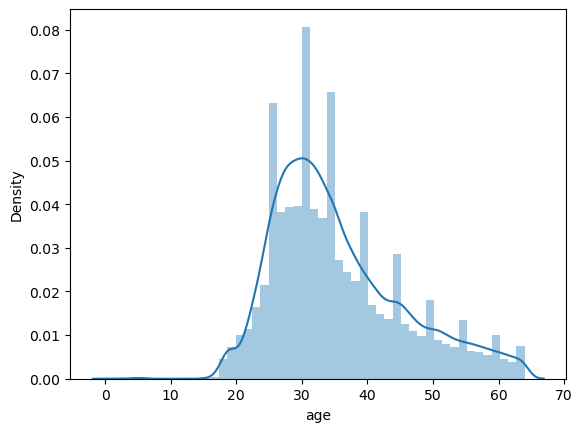

In [14]:
sns.distplot(df1[df1['age'] < 65]['age'])

In [15]:
#=============================================Users=============================================

#age

df1 = df1[(df1['age'] >= 18) & (df1['age'] < 120)]
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

#first_affiliate_tracked

df1 = df1[~ df1['first_affiliate_tracked'].isna()]

In [16]:
df1.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

## 1.4 Change Type

In [18]:
#date_account_created

df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

#timestamp_first_active

df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format = '%Y%m%d%H%M%S')

#age

df1['age'] = df1['age'].astype(np.int64)

df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.5 Check Balanced Data

In [19]:
df1['country_destination'].value_counts(normalize = True)

NDF      0.446910
US       0.392122
other    0.061291
FR       0.029940
IT       0.016435
GB       0.014337
ES       0.013750
CA       0.008682
DE       0.006863
NL       0.004855
AU       0.003533
PT       0.001281
Name: country_destination, dtype: float64

## 1.6 Descriptive Data

### 1.6.1 General

In [20]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])
time_attributes = df1.select_dtypes(include = ['datetime64[ns]'])

### 1.6.2 Numerical Users

In [21]:
#Central Tendency - Mean, Median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion Tendency - Max, Min, Std, Range, Skew, Kurtosis

dt1 = pd.DataFrame(num_attributes.apply(max)).T
dt2 = pd.DataFrame(num_attributes.apply(min)).T
dt3 = pd.DataFrame(num_attributes.apply(np.std)).T
dt4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dt5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dt6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

ct = pd.concat([dt1,dt2,dt4,ct1,ct2,dt3,dt5,dt6]).T.reset_index()
ct.columns = ['Attributes','Max','Min','Range','Mean','Median','Std','Skew','Kurtosis']
ct

,Attributes,Max,Min,Range,Mean,Median,Std,Skew,Kurtosis
0,age,115.0,18.0,97.0,37.420789,34.0,13.933666,2.093173,6.527634
1,signup_flow,25.0,0.0,25.0,2.519103,0.0,6.604828,2.706288,5.929936


### 1.6.3 Categorical Users

In [23]:
cat_attributes.drop('id',axis=1).describe().T

,count,unique,top,freq
gender,122546,4,FEMALE,56306
signup_method,122546,3,basic,66025
language,122546,25,en,118161
affiliate_channel,122546,8,direct,79058
affiliate_provider,122546,17,direct,78919
first_affiliate_tracked,122546,7,untracked,64679
signup_app,122546,4,Web,108210
first_device_type,122546,9,Mac Desktop,57923
first_browser,122546,41,Chrome,41737
country_destination,122546,12,NDF,54767


# 2.0 Feature Engineering

In [190]:
df2 = df1.copy()

In [192]:
df2.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


## 2.1 New Features

In [199]:
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%d-%m-%Y'))
df2['date_account_created'] = pd.to_datetime(df2['date_account_created'].dt.strftime('%d-%m-%Y'))


#days from first active up to account created

df2['days_from_account_created_until_active'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

#days from first active until account created

df2['days_from_first_active_until_account_created'] = (df2['first_active'] - df2['date_account_created']).apply(lambda x: x.days)



#===============================First Active=========================================================

#Year of first active

df2['year_first_active'] = df2['first_active'].dt.year

#Month of first active

df2['month_first_active'] = df2['first_active'].dt.month

#Day of first active

df2['day_first_active'] = df2['first_active'].dt.day

#Day of week of first active

df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

#Week of year first active

df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear


#===============================date account created=========================================================


#Year of account created

df2['year_account_created'] = df2['date_account_created'].dt.year

#Month of account created

df2['month_account_created'] = df2['date_account_created'].dt.month

#Day of account created

df2['day_account_created'] = df2['date_account_created'].dt.day

#Day of week of account created

df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

#Week of year account created

df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

#===============================station_of_year=========================================================


df2['station_of_year'] = df2['date_account_created'].apply(obter_estacao)

#==============================type_age============================================================

df2['type_age'] = df2['age'].apply(age)

# 3.0 Data Filtering

In [201]:
df3 = df2.copy()

## 3.1 Filtering rows

In [202]:
#Filtering rows
#Age - greater more than 15 and lower than 120

df3 = df3[(df3['age'] > 15) & (df3['age'] < 120)]

## 3.2 Filtering columns

In [203]:
cols = ['id','date_account_created','timestamp_first_active','first_active'] #original datetime

# 4.0 Data Balanced

In [204]:
df4 = df3.drop(cols, axis = 1)

In [205]:
# columns numerical

col_num = df4.select_dtypes(include = ['int64','float64']).columns.tolist()

# columns categorical

col_cat = df4.select_dtypes(exclude = ['int64','float64','datetime64[ns]']).drop(['country_destination'], axis = 1).columns.tolist()

# Encoder

ohe = pp.OneHotEncoder()

df4_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(), index = df4.index)

#Join

df42 = pd.concat([df4[col_num], df4_dummy], axis = 1)

df42.columns = df42.columns.astype(str)

## 4.1 SMOTE + TOMEKLINK

In [212]:
ratio_balanced = {'NDF': 54852,
 'US': 48057,
 'other': 7511*6,
 'FR': 3669*11,
 'IT': 2014*20,
 'GB': 1758*23,
 'ES': 1685*23,
 'CA': 1064*37,
 'DE': 841*47,
 'NL': 595*67,
 'AU': 433*92,
 'PT': 157*254}

ratio_balanced

{'NDF': 54852,
 'US': 48057,
 'other': 45066,
 'FR': 40359,
 'IT': 40280,
 'GB': 40434,
 'ES': 38755,
 'CA': 39368,
 'DE': 39527,
 'NL': 39865,
 'AU': 39836,
 'PT': 39878}

In [213]:
#definir um sample (amostra)

smt = c.SMOTETomek(sampling_strategy = ratio_balanced, random_state = 32, n_jobs = -1)

#apply the sample

x_smt, y_smt = smt.fit_resample(df42, df4['country_destination'])


In [214]:
#Numerical data

df43 = x_smt[col_num]

#categorical data

df44 = x_smt.drop(col_num, axis = 1)
df45 = pd.DataFrame(ohe.inverse_transform(df44), columns = col_cat, index = df44.index)

#Join numerical data

df46 = pd.concat([df43, df45], axis = 1)
df46['country_destination'] = y_smt

In [215]:
df46.to_csv('C:/Users/gabriel.ferreira/repos/PA/P001-AirBNB/df46.csv')

# 5.0 Data Preparation

In [227]:
df46 = pd.read_csv('C:/Users/gabriel.ferreira/repos/PA/P001-AirBNB/df46.csv')

## 5.1 Univariate Analysis - Feature Behaviour (Unbalanced Data)

In [52]:
df51 = df4.copy()

**H02** Em todos os destinos, os usuários levam 03 dias, em média, para fazer o cadastro no site

<AxesSubplot: xlabel='country_destination', ylabel='days_from_account_created_until_active'>

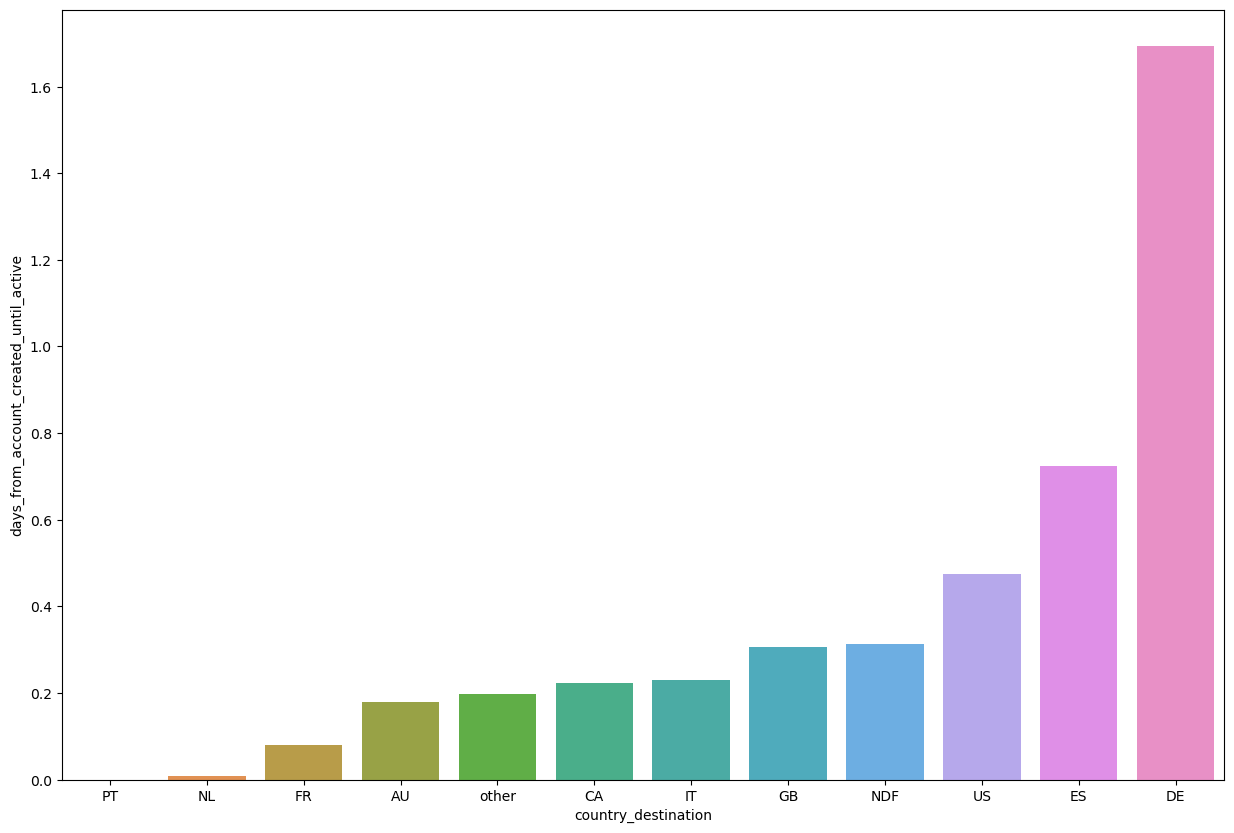

In [60]:
plt.figure(figsize = (15,10))

aux1 = df51[['days_from_account_created_until_active','country_destination']].\
        groupby('country_destination').mean().sort_values('days_from_account_created_until_active').reset_index()

sns.barplot(x = 'country_destination',y = 'days_from_account_created_until_active', data = aux1)

**H04** Usários do sexo feminino fazem 10% mais reservas para países fora dos USA

In [ ]:
aux1 = df51.loc[df51['gender'] == 'FEMALE',['gender','country_destination']]

aux11 = aux1[aux1['country_destination'] == 'US']

aux11 = aux11[['gender','country_destination']].groupby('gender').count().reset_index()

aux12 = aux1[aux1['country_destination'] != 'US']

aux12 = aux12[['gender','country_destination']].groupby('gender').count().reset_index()


aux13 = (35295 / 21067) * 100

aux13

**H05** O canal de marketing Google representa 40% das reservas para países fora dos USA

In [ ]:
aux1 = df51.loc[df51['affiliate_provider'] == 'google',:]
aux1 = aux1[['affiliate_provider','country_destination']].groupby('country_destination').count().\
            sort_values('affiliate_provider', ascending = False).reset_index()

aux1

aux1.value_counts(normalize = True)



**H06** O destino USA representa mais de 20% em todos os canais

In [ ]:
aux1 = df51[['country_destination','affiliate_channel']].groupby('country_destination').\
            count().reset_index()

aux1['affiliate_channel_percent'] = (aux1['affiliate_channel'] / aux1['affiliate_channel'].sum())*100

aux1

**H07** A idade média das pessoas é de 35 anos em todos os destinos

In [ ]:
aux1 = df51[['age','country_destination']].groupby('country_destination').\
            mean().sort_values('age', ascending = False).reset_index()

aux1

**H08** A porcentagem de usuários que usam o site na lingua inglês americano para reservar acomodações em qualquer destino é maior que 90%

In [ ]:
aux1 = df51['language'].value_counts(normalize = True)

aux1

**H09** O número de reservas do AirBNB é crescente ao longo dos anos

In [ ]:
plt.figure(figsize = (15,10))

aux1 = df51[['year_first_booking','country_destination']].groupby('year_first_booking').count().reset_index()

sns.barplot(x = 'year_first_booking', y = 'country_destination', data = aux1)

## 5.2 Bivariate Analysis - Feature Behaviour (Balanced Data)

In [218]:
df52 = df46.copy()

### 5.2.1 Univariate Analysis

In [220]:
#profile = ProfileReport(df52, title = 'AirBNB report')
#profile.to_file(output_file = 'airbnb_booking_statistics_after_cleaning.html')

### 5.2.2 Bivariate Analysis

### 5.2.3 Multivariate Analysis

<AxesSubplot: >

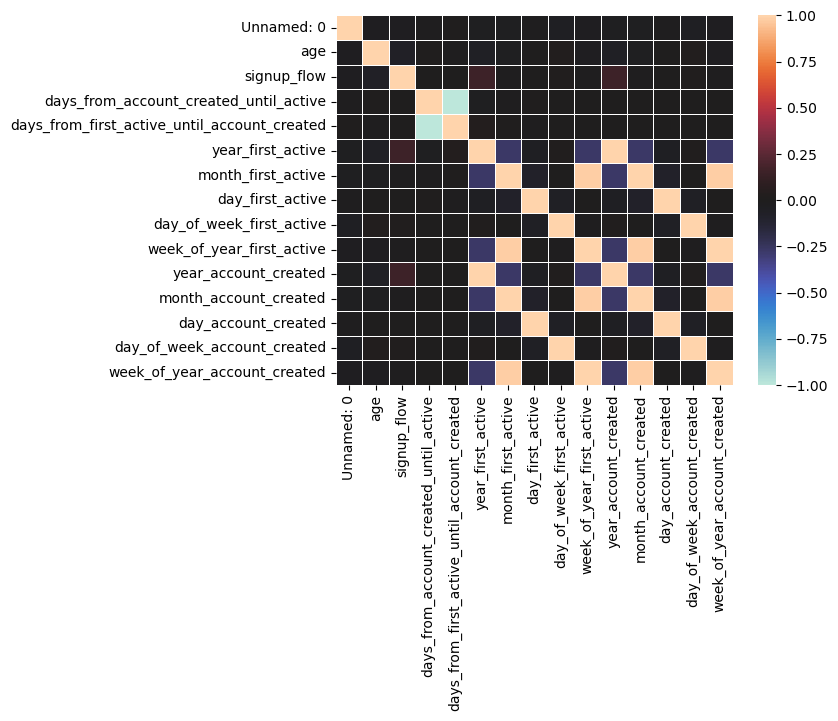

In [221]:
corr = df52.corr()
sns.heatmap(corr,center=0, linewidths=.5)

In [114]:
cols = ['Unnamed: 0', 'days_from_first_active_until_account_created', 'year_account_created', 'month_account_created',
       'week_of_year_account_created', 'day_account_created', 'day_of_week_account_created', 'language'] # High correlation

# 6.0 Data Preparation

In [380]:
df6 = df46.drop(df46[['Unnamed: 0', 'language']], axis = 1)
df6.shape

(491113, 25)

In [381]:
df6.dtypes

age                                              int64
signup_flow                                      int64
days_from_account_created_until_active           int64
days_from_first_active_until_account_created     int64
year_first_active                                int64
month_first_active                               int64
day_first_active                                 int64
day_of_week_first_active                         int64
week_of_year_first_active                        int64
year_account_created                             int64
month_account_created                            int64
day_account_created                              int64
day_of_week_account_created                      int64
week_of_year_account_created                     int64
gender                                          object
signup_method                                   object
affiliate_channel                               object
affiliate_provider                              object
first_affi

In [385]:
df_test['signup_method'].unique()

array(['facebook', 'basic', 'google', 'weibo'], dtype=object)

## 6.1 Rescaling

In [259]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [260]:
# Age - Standartization

df6['age'] = ss.fit_transform(df6[['age']].values)

#signup_flow - Robust Scaler

df6['signup_flow'] = rs.fit_transform(df6[['signup_flow']].values)

#days_from_account_created_until_active - Robust Scaler

df6['days_from_account_created_until_active'] = rs.fit_transform(df6[['days_from_account_created_until_active']].values)

#days_from_first_active_until_account_created

df6['days_from_first_active_until_account_created'] = rs.fit_transform(df6[['days_from_first_active_until_account_created']].values)

#year_first_active - Min Max Scaler

df6['year_first_active'] = mms.fit_transform(df6[['year_first_active']].values)

#year_account_created

df6['year_account_created'] = mms.fit_transform(df6[['year_account_created']].values)


## 6.2 Encoding

In [261]:
ohe = pp.OneHotEncoder()
le = pp.LabelEncoder()

In [262]:
#gender - OHE

df6 = pd.get_dummies(df6, prefix = ['gender'], columns = ['gender'])

#signup_method - OHE

df6 = pd.get_dummies(df6, prefix = ['signup_method'], columns = ['signup_method'])

#signup_app - OHE

df6 = pd.get_dummies(df6, prefix = ['signup_app'], columns = ['signup_app'])

#affiliate_channel - Label encoding

df6['affiliate_channel'] = np.int64(le.fit_transform(df6[['affiliate_channel']].values))

#affiliate_provider - Label encoding

df6['affiliate_provider'] = np.int64(le.fit_transform(df6[['affiliate_provider']].values))

#first_affiliate_tracked - Label encoding

df6['first_affiliate_tracked'] = np.int64(le.fit_transform(df6[['first_affiliate_tracked']].values))

#first_device_type - Label encoding

df6['first_device_type'] = np.int64(le.fit_transform(df6[['first_device_type']].values))

#first_browser - Label encoding

df6['first_browser'] = np.int64(le.fit_transform(df6[['first_browser']].values))

#station_of_year

df6 = pd.get_dummies(df6, prefix = ['station_of_year'], columns = ['station_of_year'])

#type_age

df6 = pd.get_dummies(df6, prefix = ['type_age'], columns = ['type_age'])

## 6.3 Transformation

In [263]:
#day_first_active

df6['day_first_active_sin'] = df6['day_first_active'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df6['day_first_active_cos'] = df6['day_first_active'].apply(lambda x: np.cos(x * (2*np.pi/7)))

#day_of_week_first_active

df6['day_of_week_first_active_sin'] = df6['day_of_week_first_active'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df6['day_of_week_first_active_cos'] = df6['day_of_week_first_active'].apply(lambda x: np.cos(x * (2*np.pi/7)))

#day_of_week_first_active

df6['day_of_week_first_active_sin'] = df6['day_of_week_first_active'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df6['day_of_week_first_active_cos'] = df6['day_of_week_first_active'].apply(lambda x: np.cos(x * (2*np.pi/7)))

#week_of_year_first_active

df6['week_of_year_first_active_sin'] = df6['week_of_year_first_active'].apply(lambda x: np.sin(x * (2*np.pi/52)))
df6['week_of_year_first_active_cos'] = df6['week_of_year_first_active'].apply(lambda x: np.cos(x * (2*np.pi/52)))

#=======================================================================================================================

#day_account_created

df6['day_account_created_sin'] = df6['day_account_created'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df6['day_account_created_cos'] = df6['day_account_created'].apply(lambda x: np.cos(x * (2*np.pi/7)))

#day_of_week_account_created

df6['day_of_week_account_created_sin'] = df6['day_of_week_account_created'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df6['day_of_week_account_created_cos'] = df6['day_of_week_account_created'].apply(lambda x: np.cos(x * (2*np.pi/7)))

#day_of_week_account_created

df6['day_of_week_account_created_sin'] = df6['day_of_week_account_created'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df6['day_of_week_account_created_cos'] = df6['day_of_week_account_created'].apply(lambda x: np.cos(x * (2*np.pi/7)))

#week_of_year_account_created

df6['week_of_year_account_created_sin'] = df6['week_of_year_account_created'].apply(lambda x: np.sin(x * (2*np.pi/52)))
df6['week_of_year_account_created_cos'] = df6['week_of_year_account_created'].apply(lambda x: np.cos(x * (2*np.pi/52)))


# 7.0 Base Model

In [273]:
df7 = df6.copy()

In [274]:
x = df7.drop(columns = 'country_destination')
y = df7['country_destination']

In [275]:
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size =0.2, random_state = 46)

In [276]:
x_train, x_val, y_train, y_val = ms.train_test_split(x_train, y_train, test_size =0.2, random_state = 46)

In [277]:
country_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k = y_val.shape[0]
weights = df1['country_destination'].value_counts(normalize = True).sort_index().tolist()

yhat_random = random.choices(population = country_list, weights = weights, k = k )

Accuracy 0.09021609101784214
Balanced Accuracy 0.08386654627497658
Kappa Score 0.0006724733567450292


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

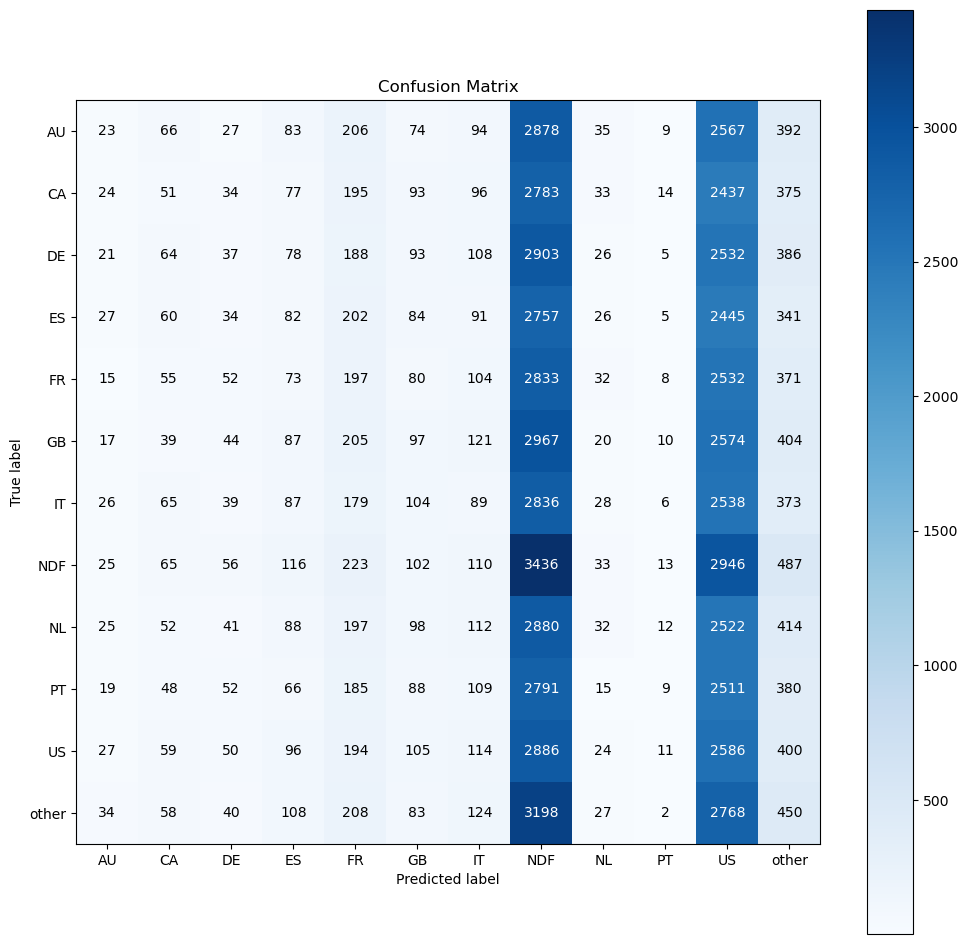

In [278]:
# Accuracy

acc_random = m.accuracy_score(y_val, yhat_random)
print('Accuracy {}'.format(acc_random))

# Balanced accuracy

balanced_acc_random = m.balanced_accuracy_score(y_val, yhat_random)

print('Balanced Accuracy {}'.format(balanced_acc_random))

# Kappa Score

kappa_random = m.cohen_kappa_score(y_val, yhat_random)

print('Kappa Score {}'.format(kappa_random))


# Confusion Matrix

mt.plot_confusion_matrix(y_val, yhat_random, normalize = False, figsize=(12,12))

In [289]:
y_train = le.fit_transform(y_train)

model = XGBClassifier(eval_metric = 'mlogloss', n_jobs= -1 , objective = 'multi:softproba', random_state = 123)
model = model.fit(x_train, y_train)
yhat_knn_base_model = model.predict(x_val)

In [293]:
yhat_base_model = le.inverse_transform(yhat_knn_base_model)

Accuracy 0.5500649036626027
Balanced Accuracy 0.5550153036907121
Kappa Score 0.5090274103501414


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

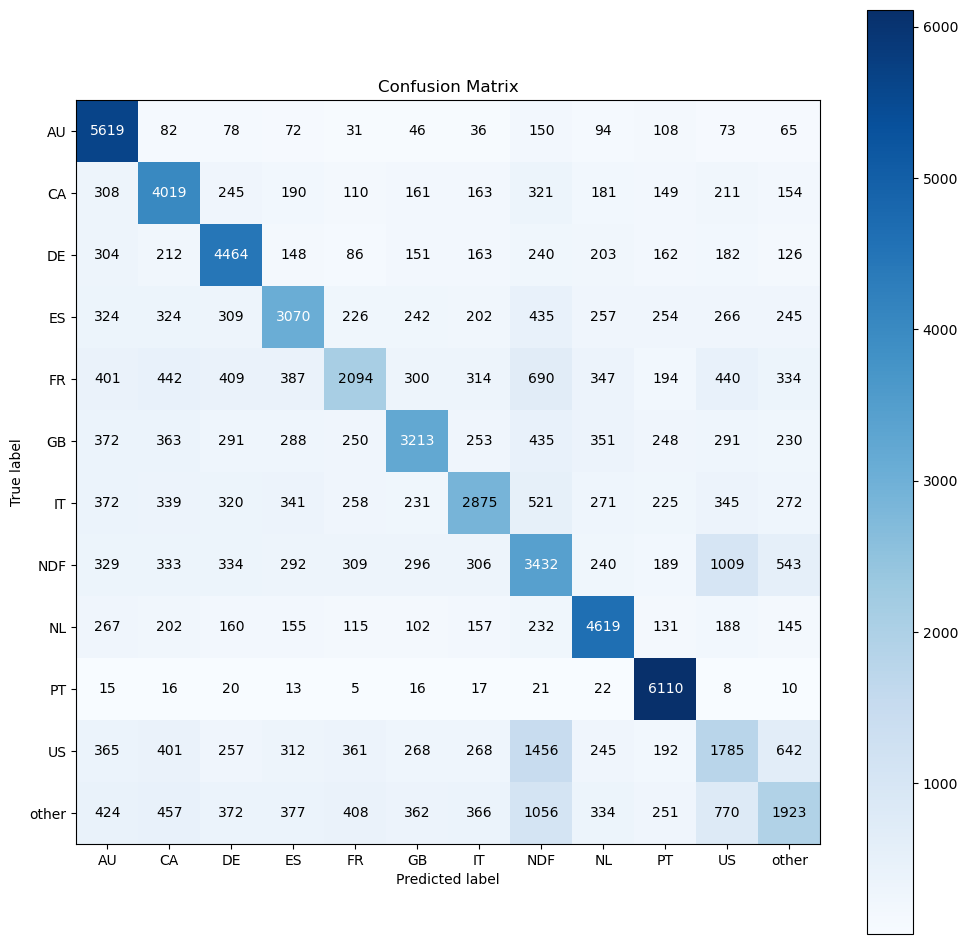

In [295]:
# Accuracy

acc_base_model = m.accuracy_score(y_val, yhat_base_model)
print('Accuracy {}'.format(acc_base_model))

# Balanced accuracy

balanced_base_model = m.balanced_accuracy_score(y_val, yhat_base_model)

print('Balanced Accuracy {}'.format(balanced_base_model))

# Kappa Score

kappa_base_model = m.cohen_kappa_score(y_val, yhat_base_model)

print('Kappa Score {}'.format(kappa_base_model))


# Confusion Matrix

mt.plot_confusion_matrix(y_val, yhat_base_model, normalize = False, figsize=(12,12))

# 8.0 Feature Selection

## 8.1 Feature Importance

In [333]:
feature_imp = pd.DataFrame({'Feature': x_train.columns, 'Value': model.feature_importances_})

feature_imp.sort_values(by = "Value", ascending = False)

important_cols = feature_imp[feature_imp["Value"] > 0.005]["Feature"].to_list()

len(important_cols)

48

In [328]:
feature_imp.sort_values(by = "Value", ascending = False)

,Feature,Value
24,signup_method_facebook,0.073171
9,year_account_created,0.049419
12,day_of_week_account_created,0.026891
11,day_account_created,0.026561
10,month_account_created,0.026388
48,week_of_year_account_created_cos,0.025799
36,type_age_Young,0.024518
31,station_of_year_Spring,0.023745
13,week_of_year_account_created,0.023207
21,gender_MALE,0.023167


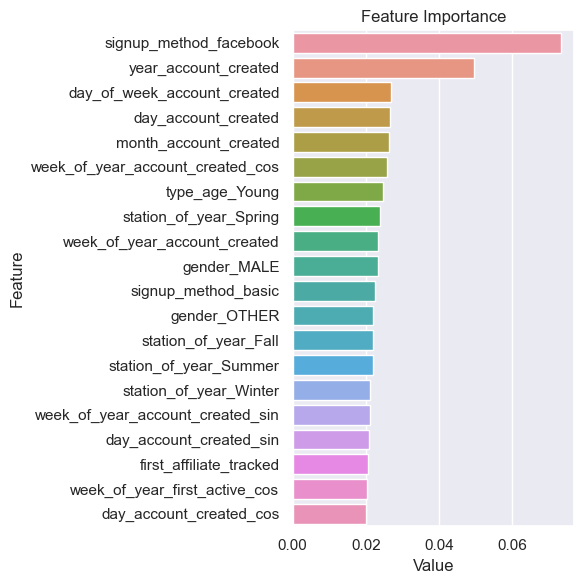

In [309]:
feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': x_train.columns})

plt.figure(figsize=(6, 6))
sns.set(font_scale=1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",ascending=False)[0:20])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## 8.2 BorutaPy

In [77]:
x = df7.drop(df7[['country_destination','country_destination']], axis = 1).values
y = df7['country_destination'].copy().values

### 8.2.1 BorutaPy with Random forest regressor

In [78]:
#define random forest regressor, with utilising all cores and sampling in proportion to y labels
#forest = RandomForestRegressor(max_depth = 5, random_state = 42)

#define Boruta feature selection method
#feat_selector = BorutaPy(forest, n_estimators='auto',max_iter = 70, verbose=2, random_state=42)

#find all relevant features
#feat_selector.fit(x, y)

In [79]:
# check selected features
#feat_selector.support_

In [80]:
#x = pd.DataFrame(x)
#df7_aux = df7.drop(['country_destination'], axis = 1)
#x.columns = df7_aux.columns
#x.columns[feat_selector.support_]

In [81]:
cols = ['age', 'signup_flow', 'days_from_account_created_until_first_booking',
       'day_first_booking', 'day_of_week_first_booking',
       'year_account_created', 'day_account_created',
       'day_of_week_account_created', 'week_of_year_account_created',
       'affiliate_channel', 'first_affiliate_tracked', 'signup_app_Web',
       'day_first_booking_sin', 'day_first_booking_cos',
       'day_of_week_first_booking_sin', 'day_of_week_first_booking_cos',
       'day_account_created_sin', 'day_account_created_cos',
       'day_of_week_account_created_cos', 'week_of_year_account_created_sin',
       'week_of_year_account_created_cos']

In [82]:
y = le.inverse_transform(y)

# 9.0 Machine Learning Model

In [329]:
df9 = df7.drop(columns = 'days_from_first_active_until_account_created').copy()

In [372]:
df9

,age,signup_flow,days_from_account_created_until_active,year_first_active,month_first_active,day_first_active,day_of_week_first_active,week_of_year_first_active,year_account_created,month_account_created,...,day_of_week_first_active_sin,day_of_week_first_active_cos,week_of_year_first_active_sin,week_of_year_first_active_cos,day_account_created_sin,day_account_created_cos,day_of_week_account_created_sin,day_of_week_account_created_cos,week_of_year_account_created_sin,week_of_year_account_created_cos
0,1.390215,3.0,387.0,0.0,9,6,6,36,0.00,9,...,-0.781831,0.623490,-0.935016,-0.354605,-9.797174e-16,1.000000,0.781831,0.623490,-1.000000,-1.836970e-16
1,0.366942,0.0,558.0,0.0,10,31,5,44,0.25,5,...,-0.974928,-0.222521,-0.822984,0.568065,-9.749279e-01,-0.222521,0.433884,-0.900969,0.748511,-6.631227e-01
2,0.293851,0.0,398.0,0.0,8,12,2,33,0.00,9,...,0.974928,-0.222521,-0.748511,-0.663123,-4.898587e-16,1.000000,0.781831,0.623490,-0.970942,-2.393157e-01
3,0.659306,0.0,0.0,0.2,2,1,0,5,0.00,2,...,0.000000,1.000000,0.568065,0.822984,7.818315e-01,0.623490,0.000000,1.000000,0.568065,8.229839e-01
4,0.732397,0.0,0.0,0.2,3,1,0,9,0.00,3,...,0.000000,1.000000,0.885456,0.464723,7.818315e-01,0.623490,0.000000,1.000000,0.885456,4.647232e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491108,0.220761,0.0,0.0,0.8,4,22,0,17,0.75,4,...,0.000000,1.000000,0.885456,-0.464723,7.818315e-01,0.623490,0.000000,1.000000,0.885456,-4.647232e-01
491109,-0.144694,0.0,0.0,0.6,2,6,0,6,0.50,2,...,0.000000,1.000000,0.663123,0.748511,-7.818315e-01,0.623490,0.000000,1.000000,0.663123,7.485107e-01
491110,-0.510148,0.0,0.0,1.0,5,21,2,21,1.00,5,...,0.974928,-0.222521,0.568065,-0.822984,-7.347881e-16,1.000000,0.974928,-0.222521,0.568065,-8.229839e-01
491111,-0.510148,0.0,0.0,1.0,1,13,0,3,1.00,1,...,0.000000,1.000000,0.354605,0.935016,-7.818315e-01,0.623490,0.000000,1.000000,0.354605,9.350162e-01


## 9.1 Split in Train and Test

In [334]:
x = df9.drop(['country_destination'], axis = 1)
y = df9['country_destination'].copy()

In [335]:
#split train and test data

x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size = 0.2, random_state = 42)

In [336]:
#split train and validation data

x_train, x_val, y_train, y_val = ms.train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)


In [337]:
print('Number of rows: {}'.format(x_train.shape[0]))
print('Number of features: {}'.format(x_train.shape[1]))
print('Number of classes: {}'.format(y_train.nunique()))

Number of rows: 314312
Number of features: 48
Number of classes: 12


## 9.2 KNN

In [338]:
x_train_knn = x_train
y_train_knn = y_train

In [339]:
model_knn = KNeighborsClassifier(n_neighbors = 5)

model_knn.fit(x_train_knn, y_train_knn)

yhat_knn = model_knn.predict(x_val)

Accuracy: 0.7792893685255415
Balanced Accuracy: 0.7928611602337577
Kappa Score: 0.7594096527101182


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

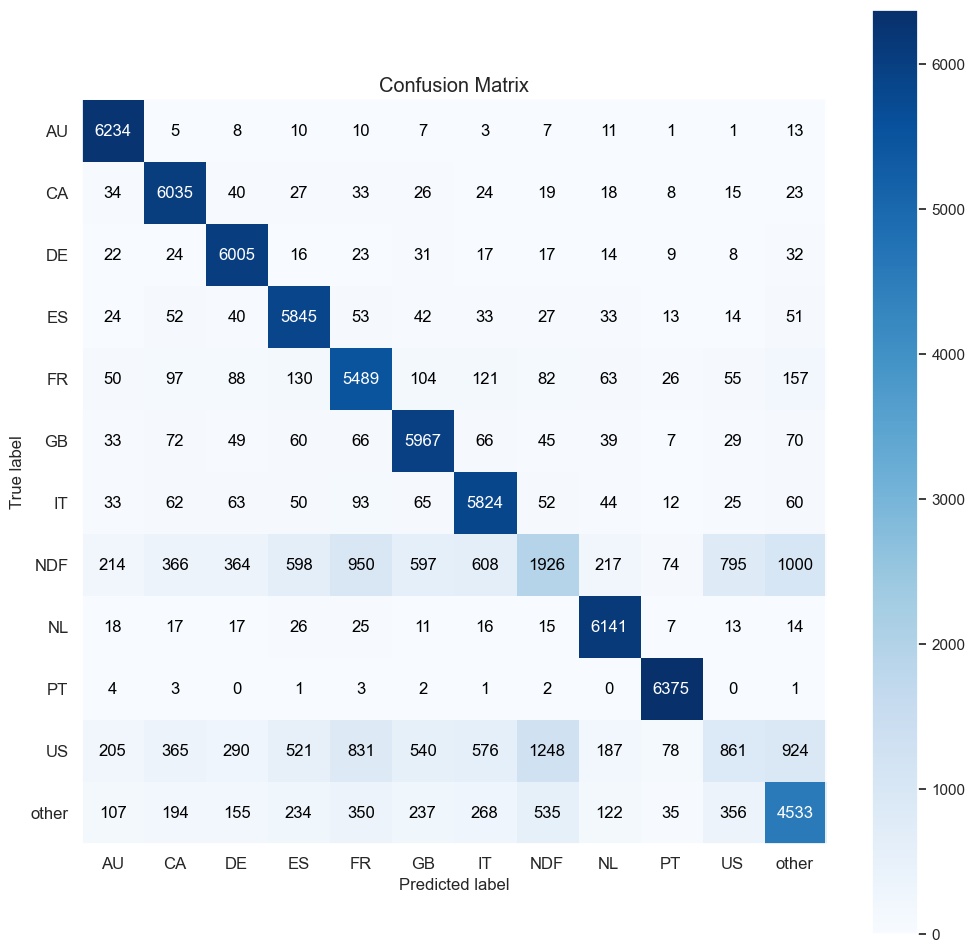

In [340]:
#Accuracy

acc_knn = m.accuracy_score(y_val, yhat_knn)

# Balanced Accuracy

balanced_acc_knn = m.balanced_accuracy_score(y_val, yhat_knn)

#Kappa score

kappa_knn = m.cohen_kappa_score(y_val, yhat_knn)

print('Accuracy: {}'.format(acc_knn))
print('Balanced Accuracy: {}'.format(balanced_acc_knn))
print('Kappa Score: {}'.format(kappa_knn))

#Matrix confusion

mt.plot_confusion_matrix(y_val, yhat_knn, normalize = False, figsize=(12,12))

## 9.3  Cross Validation - KNN

In [341]:
#generate k-fold

folds = 5
kfold = ms.StratifiedKFold(n_splits = folds, shuffle = True, random_state = 32)

balanced_fold_list = []
kappa_fold_list = []

i = 1

for train_ix, val_ix in kfold.split(x_train, y_train): #pegará as proporções das classes
    print('Fold number: {}/{}'.format(i, folds))
    
    
    #get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]

    #model definition
    
    model_knn_fold = KNeighborsClassifier(n_neighbors = 5)

    #training model
    
    model_knn_fold.fit(x_train_fold, y_train_fold)

    #prediction
    
    yhat_knn_fold = model_knn_fold.predict(x_val_fold)
    
    #Balanced Accuracy

    balanced_fold = m.balanced_accuracy_score(y_val_fold, yhat_knn_fold)
    balanced_fold_list.append(balanced_fold)

    #Kappa Score

    kappa_fold = m.cohen_kappa_score(y_val_fold, yhat_knn_fold)
    kappa_fold_list.append(kappa_fold)
    
    i = i + 1

Fold number: 1/5
Fold number: 2/5
Fold number: 3/5
Fold number: 4/5
Fold number: 5/5


# 10.0 ML Model Performance

In [342]:
#prediction

yhat_knn_final = model_knn_fold.predict(x_test)

Accuracy: 0.7604939779888621
Balanced Accuracy: 0.7724456783466377
Kappa Score: 0.738925617781873


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

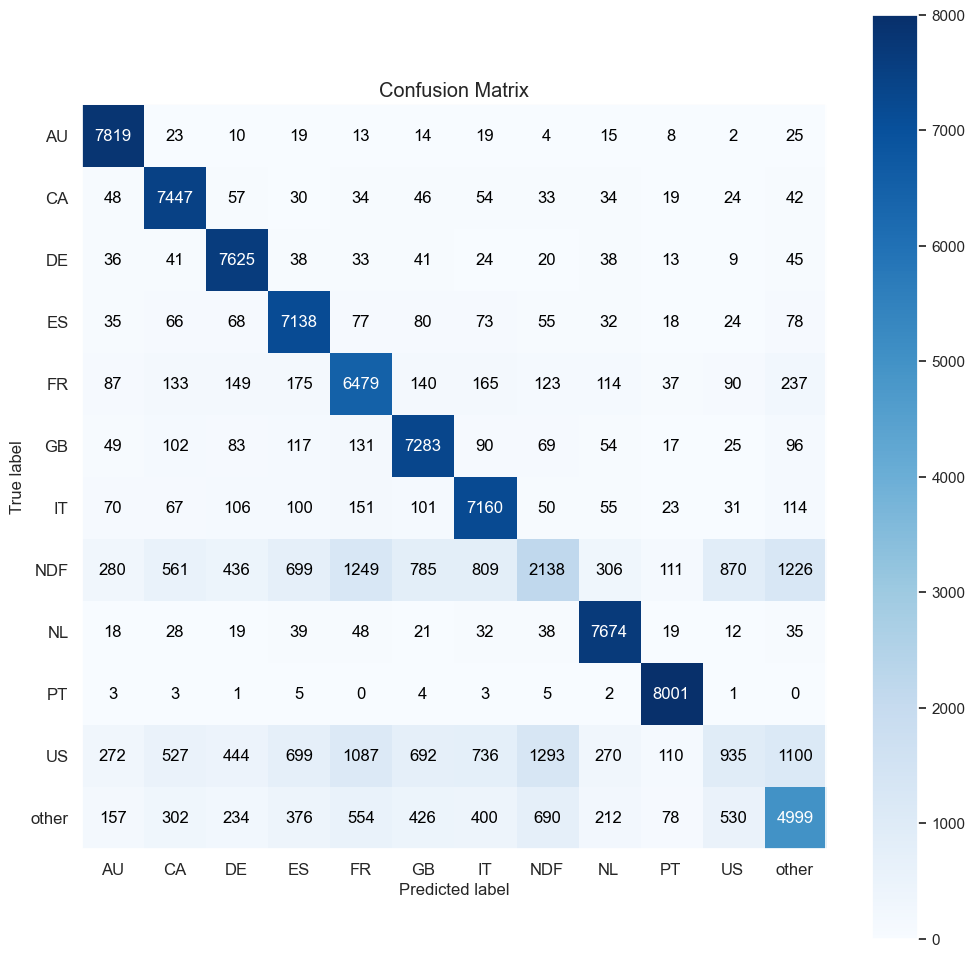

In [343]:
#Accuracy

acc_knn_cross_validation = m.accuracy_score(y_test, yhat_knn_final)

# Balanced Accuracy

balanced_knn_cross_validation = m.balanced_accuracy_score(y_test, yhat_knn_final)

#Kappa score

kappa_knn_cross_validation = m.cohen_kappa_score(y_test, yhat_knn_final)

print('Accuracy: {}'.format(acc_knn_cross_validation))
print('Balanced Accuracy: {}'.format(balanced_knn_cross_validation))
print('Kappa Score: {}'.format(kappa_knn_cross_validation))

#Matrix confusion

mt.plot_confusion_matrix(y_test, yhat_knn_final, normalize = False, figsize=(12,12))

In [344]:
data_knn = {'KNN': [acc_knn, balanced_acc_knn, kappa_knn],
           'KNN - Cross Validation': [acc_knn_cross_validation, balanced_knn_cross_validation, kappa_knn_cross_validation]}

df_comp_knn = pd.DataFrame(data_knn, index = ['Accuracy', 'Balanced Accuracy','Kappa Score'])

df_comp_knn

,KNN,KNN - Cross Validation
Accuracy,0.779289,0.760494
Balanced Accuracy,0.792861,0.772446
Kappa Score,0.759410,0.738926


# 11.0 HyperParameters

In [98]:
# Definindo os possíveis valores dos hiperparâmetros

#param_grid = {
#    'n_neighbors': [3, 5, 7],
#    'weights': ['uniform', 'distance'],
#    'metric': ['euclidean', 'manhattan']}

In [99]:
# Realizando a busca de hiperparâmetros usando validação cruzada

#knn = KNeighborsClassifier()

#grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
#grid_search.fit(x_train, y_train)

In [100]:
# Extraindo o melhor modelo e os melhores hiperparâmetros

#best_model = grid_search.best_estimator_
#best_params = grid_search.best_params_

In [101]:
# Imprimindo os melhores hiperparâmetros encontrados

#print("Melhores hiperparâmetros: {}".format(best_params))

In [345]:
model_knn_final = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 3, weights = 'distance')

In [346]:
model_knn_final.fit(x_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [347]:
yhat_knn_hiper = model_knn_final.predict(x_val)

Accuracy: 0.8345847438214259
Balanced Accuracy: 0.8457530630056255
Kappa Score: 0.819606882453117


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

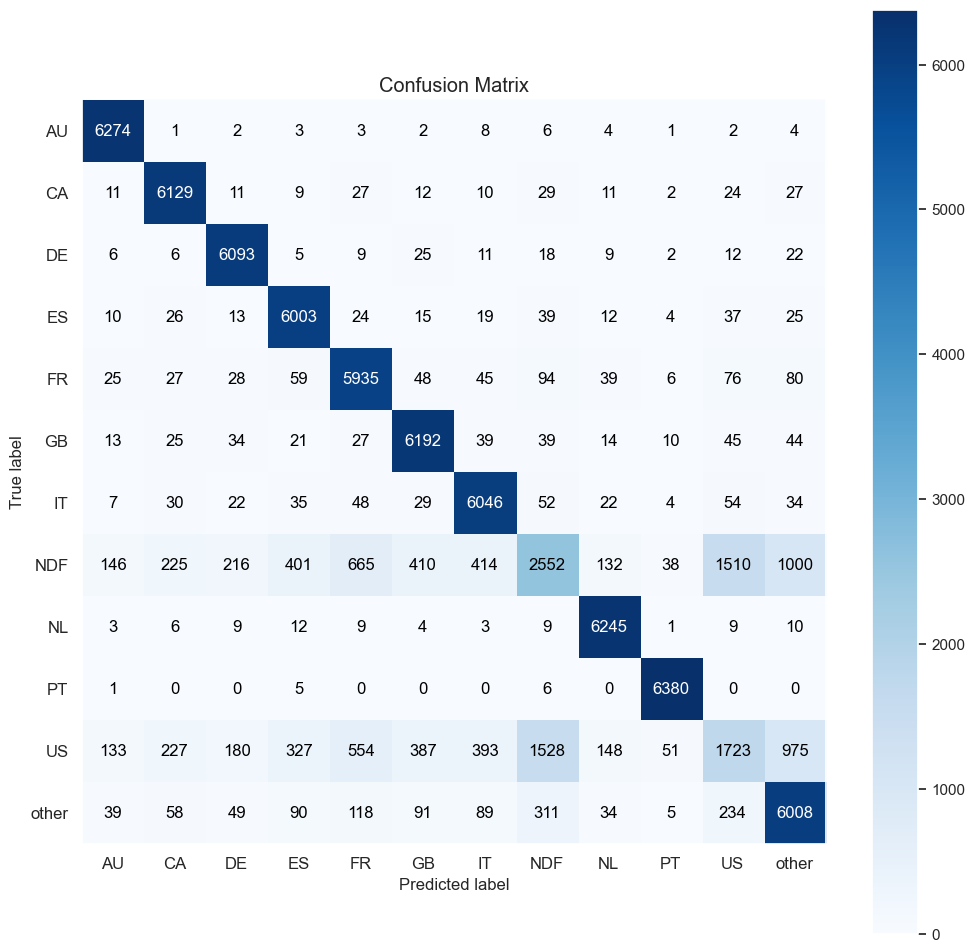

In [348]:
acc_knn_hiper = m.accuracy_score(y_val, yhat_knn_hiper)
balanced_knn_hiper = m.balanced_accuracy_score(y_val, yhat_knn_hiper)
kappa_knn_hiper = m.cohen_kappa_score(y_val, yhat_knn_hiper)

print('Accuracy: {}'.format(acc_knn_hiper))
print('Balanced Accuracy: {}'.format(balanced_knn_hiper))
print('Kappa Score: {}'.format(kappa_knn_hiper))

mt.plot_confusion_matrix(y_val, yhat_knn_hiper, normalize = False, figsize=(12,12))

In [349]:
data_knn_hiper = {'KNN': [acc_knn, balanced_acc_knn, kappa_knn],
                   'KNN - Cross Validation': [acc_knn_cross_validation, balanced_knn_cross_validation, kappa_knn_cross_validation],
                   'KNN - HiperParameters':[acc_knn_hiper, balanced_knn_hiper, kappa_knn_hiper]}

df_comp_knn_hiper = pd.DataFrame(data_knn_hiper, index = ['Accuracy', 'Balanced Accuracy','Kappa Score'])

df_comp_knn_hiper

,KNN,KNN - Cross Validation,KNN - HiperParameters
Accuracy,0.779289,0.760494,0.834585
Balanced Accuracy,0.792861,0.772446,0.845753
Kappa Score,0.759410,0.738926,0.819607


## 11.1 Save The Model

In [350]:
with open('modelo_final.pkl', 'wb') as file:
    pickle.dump(model_knn_final, file)

# 12.0 With Data Test

## 12.1 Load Data Test and Model

In [403]:
df_test

with open('modelo_final.pkl', 'rb') as file:
    modelo = pickle.load(file)

In [460]:
df_test.shape[0]

62096

## 12.2 Preparating data test

In [461]:
df_prepared = prepare_data(df_test)
df_prepared.shape[0]

33129

## 12.2 Testing

In [453]:
df_testing = df_prepared.sample(6).reset_index(drop = True)
df_testing

,age,signup_flow,days_from_account_created_until_active,year_first_active,month_first_active,day_first_active,day_of_week_first_active,week_of_year_first_active,year_account_created,month_account_created,...,day_of_week_first_active_sin,day_of_week_first_active_cos,week_of_year_first_active_sin,week_of_year_first_active_cos,day_account_created_sin,day_account_created_cos,day_of_week_account_created_sin,day_of_week_account_created_cos,week_of_year_account_created_sin,week_of_year_account_created_cos
0,-0.823205,1.086957,0.0,0.0,9,18,3,38,0.0,9,...,0.433884,-0.900969,-0.992709,-0.120537,-0.433884,-0.900969,0.433884,-0.900969,-0.992709,-0.120537
1,0.089773,0.000000,0.0,0.0,5,9,4,19,0.0,5,...,-0.433884,-0.900969,0.748511,-0.663123,0.974928,-0.222521,-0.433884,-0.900969,0.748511,-0.663123
2,5.339399,0.000000,0.0,0.0,11,8,5,45,0.0,11,...,-0.974928,-0.222521,-0.748511,0.663123,0.781831,0.623490,-0.974928,-0.222521,-0.748511,0.663123
3,-0.975368,1.086957,0.0,0.0,7,19,5,29,0.0,7,...,-0.974928,-0.222521,-0.354605,-0.935016,-0.974928,-0.222521,-0.974928,-0.222521,-0.354605,-0.935016
4,-0.062390,0.000000,0.0,0.0,8,23,5,34,0.0,8,...,-0.974928,-0.222521,-0.822984,-0.568065,0.974928,-0.222521,-0.974928,-0.222521,-0.822984,-0.568065
5,2.524383,0.000000,0.0,0.0,7,20,6,29,0.0,7,...,-0.781831,0.623490,-0.354605,-0.935016,-0.781831,0.623490,-0.781831,0.623490,-0.354605,-0.935016


In [454]:
yhat_test = modelo.predict(df_testing)

In [455]:
yhat_test

array(['US', 'NDF', 'NDF', 'DE', 'NL', 'NDF'], dtype=object)

In [456]:
yhat_test = pd.DataFrame(yhat_test)
yhat_test = yhat_test.rename(columns = {0: 'Predict'})

In [446]:
df_testing['Predict'] = yhat_test['Predict']

In [457]:
df1_test = pd.concat([df_testing, yhat_test], axis = 1)
df1_test

,age,signup_flow,days_from_account_created_until_active,year_first_active,month_first_active,day_first_active,day_of_week_first_active,week_of_year_first_active,year_account_created,month_account_created,...,day_of_week_first_active_cos,week_of_year_first_active_sin,week_of_year_first_active_cos,day_account_created_sin,day_account_created_cos,day_of_week_account_created_sin,day_of_week_account_created_cos,week_of_year_account_created_sin,week_of_year_account_created_cos,Predict
0,-0.823205,1.086957,0.0,0.0,9,18,3,38,0.0,9,...,-0.900969,-0.992709,-0.120537,-0.433884,-0.900969,0.433884,-0.900969,-0.992709,-0.120537,US
1,0.089773,0.000000,0.0,0.0,5,9,4,19,0.0,5,...,-0.900969,0.748511,-0.663123,0.974928,-0.222521,-0.433884,-0.900969,0.748511,-0.663123,NDF
2,5.339399,0.000000,0.0,0.0,11,8,5,45,0.0,11,...,-0.222521,-0.748511,0.663123,0.781831,0.623490,-0.974928,-0.222521,-0.748511,0.663123,NDF
3,-0.975368,1.086957,0.0,0.0,7,19,5,29,0.0,7,...,-0.222521,-0.354605,-0.935016,-0.974928,-0.222521,-0.974928,-0.222521,-0.354605,-0.935016,DE
4,-0.062390,0.000000,0.0,0.0,8,23,5,34,0.0,8,...,-0.222521,-0.822984,-0.568065,0.974928,-0.222521,-0.974928,-0.222521,-0.822984,-0.568065,NL
5,2.524383,0.000000,0.0,0.0,7,20,6,29,0.0,7,...,0.623490,-0.354605,-0.935016,-0.781831,0.623490,-0.781831,0.623490,-0.354605,-0.935016,NDF
